<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Statistical Analysis Number of Cells - Femur vs Liver</h2>
    <br>02 September 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">   
    <h3 style="color:#483D8B;">Simone G. Riva, MSc</h3><br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sgr34@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sr31@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import matplotlib
import seaborn as sns
import sys
from scipy import stats
import math

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()
        
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.10, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.patch.set(hatch='xx', edgecolor='black')
    

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            if float(text.get_text()) == 0.0:
                text.set_text("")

            texts.append(text)
                
    return texts

In [4]:
def plotHeatmaps(dataframeIn, groupby="Cluster"):

    for key in dataframeIn.keys():

        print("\t\t\t\t\t************ %s ************"%key)
        dataframe = dataframeIn[key]
        display(dataframe)


        labels = list(set(dataframe["group1"]).union(dataframe["group2"]))

        data     = []
        clusters = list(np.unique(dataframe[groupby]))

        combinations = []
        for i, label1 in enumerate(labels):
            for j, label2 in enumerate(labels):
                if i<j:

                    filtered = dataframe[(dataframe["group1"] == label1) & (dataframe["group2"] == label2)]
                    if len(filtered) == 0:
                        filtered = dataframe[(dataframe["group2"] == label1) & (dataframe["group1"] == label2)]

                    if len(filtered) == 0:
                        continue

                    combinations.append("%s vs %s"%(label1, label2))

                    subdata = []
                    for c in clusters:
                        values = filtered[filtered[groupby]==c]["p-value"].tolist()
                        if len(values) == 0:
                            subdata.append(float('nan'))
                        elif values[0] > 1:
                            subdata.append(1)
                        else:
                            subdata.append(values[0])

                    data.append(subdata)

        df = pd.DataFrame(columns=combinations, index=clusters, data=np.array(data).T)

        fig, ax = plt.subplots(1, 1, figsize=(20, 20))

        qrates = np.array([0.0, 0.01, 0.05, 0.1, 1.0])
        norm = matplotlib.colors.BoundaryNorm(np.array([0.0, 0.01, 0.05, 0.1, 1.0]), 4)
        fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[0::][norm(x)])

        im, _ = heatmap(np.array(data).T, clusters, combinations, ax=ax,
                        cmap=plt.get_cmap("RdBu", 4), norm=norm,
                        vmin=-1, vmax=1,
                        cbar_kw=dict(ticks=[0.0, 0.01, 0.05, 0.1, 1.0], format=fmt),
                        cbarlabel="Confidence interval")
        
        annotate_heatmap(im, valfmt="{x:.2e}", size=12, fontweight="bold", textcolors=["white", "white", "white", "white"])

        plt.tight_layout()
        plt.show()

In [5]:
def __fisher_test(d, alpha):
        
    col1    = d.columns.tolist()[0]
    col2    = d.columns.tolist()[1]
    
    indices = d.index.tolist() 
    
    group1  = d[col1+" normalised"].values.tolist()
    group2  = d[col2+" normalised"].values.tolist()
    
    p_vals  = []
    diff    = []

    for idx in range(len(indices)):
        value1 = group1[idx]
        other1 = np.sum(group1)-value1
        value2 = group2[idx]
        other2 = np.sum(group2)-value2
        
        if value1 == 0 or value2 == 0:
            p_vals.append(np.nan)
        else:
            p_val  = stats.fisher_exact([[value1, value2], [other1, other2]])[1]
            p_vals.append(p_val)
                        
        if p_val >= alpha:
            diff.append('No')
        else:
            diff.append('Yes')
            
    dd = d.copy()
    dd['alpha']      = alpha
    dd['p-value']    = p_vals
    dd['difference'] = diff
    
    return dd


def  __barplot_test(d, palette, title=""):

    group1 = d[d.columns.tolist()[0]].values
    group2 = d[d.columns.tolist()[1]].values

    fig = plt.figure(figsize=(12, 5))
    sns.set(font_scale=1.5)
    sns.set_style("white")
    
    categories = d.index.tolist()
    p1 = plt.bar(categories, group1, 0.55, color=palette[0])
    p2 = plt.bar(categories, group2, 0.55, bottom=group1, color=palette[1])
    
    sns.despine(offset=10, trim=False)

    plt.xticks(rotation=90)
    plt.legend((p1[0], p2[0]), (d.columns.tolist()[0], d.columns.tolist()[1]))
    plt.ylabel('Number of cells')

    plt.title(title)
    return fig
        
#     plt.show(block=False)



def __chi_test(dd, alpha, palette):
    
    col1 = dd.columns.tolist()[0]
    col2 = dd.columns.tolist()[1]
        
    sum1 = np.sum(dd[col1].values.tolist())
    sum2 = np.sum(dd[col2].values.tolist())
    
    avg = (sum1+sum2)/2
    
    dd[col1+" normalised"] = np.round(avg*(np.array(dd[col1].values.tolist())/sum1), decimals=0).astype(int)
    dd[col2+" normalised"] = np.round(avg*(np.array(dd[col2].values.tolist())/sum2), decimals=0).astype(int)
    
    
    group1 = dd[col1+" normalised"].values.tolist()
    group2 = dd[col2+" normalised"].values.tolist()

    d = dd.copy()
    
    indexNames = d[(d[col1+" normalised"] < 1) | (d[col2+" normalised"] < 1)].index
    d.drop(indexNames , inplace=True)
    
    print('******************** Analysing %s and %s ********************' %(col1+" normalised", col2+" normalised"))
    print('* -> All clusters:', dd.index.tolist())
    display(dd)
    fig = __barplot_test(dd[[col1, col2]], palette, title="All original clusters")
    fig = __barplot_test(dd[[col1+" normalised", col2+" normalised"]], palette, title="All normalised clusters")
    
    if len(d.index.tolist())==0:
        print('\t * All entries have a value less than 5')
        print("\t       Running Fisher's exact test...")
        dd_fisher = __fisher_test(dd, alpha)
        return dd_fisher
   
    else:
        print('* -> Chi-squared clusters:', d.index.tolist())
        display(d)
        fig = __barplot_test(d[[col1, col2]], palette, title="Chi-squared clusters")
        fig = __barplot_test(d[[col1+" normalised", col2+" normalised"]], palette, title="Chi-squared normalised clusters")

        dd_fisher = None
    
    table = np.array([d[col1+" normalised"].values, 
                      d[col2+" normalised"].values])
                
    p_val = stats.chi2_contingency(table)[1]
    if p_val >= alpha:
        print('\t * H0: the distribution of the outcome is indipendent of the groups')
        print('\t       alpha equal to %.2e' %(alpha))
        print('\t       p-value equal to %.2e' %(p_val))
    else:
        print('\t * H1: the distribution of the outcome is dipendent of the groups')
        print('\t       alpha equal to %.2e' %(alpha))
        print('\t       p-value equal to %.2e' %(p_val))
        print()
        print("\t       Running Fisher's exact test...")
        dd_fisher = __fisher_test(dd, alpha)
    
    print()
    
    return dd_fisher

# Loading the object

In [6]:
merged = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_annotated.h5ad')

# Donut plots: number of femur and liver cells per cluster

In [7]:
merged = merged[(merged.obs["origin"] == "Femur") | (merged.obs["origin"] == "Liver")]

In [8]:
fc.plotPieCharts(merged, variable="origin", group_by="Cluster")

# Chi-squared test and Fisher's exact test

## Selecting the gates with both organs and normalising in [0, 100]

In [9]:
femur = np.unique(merged[merged.obs["origin"] == "Femur"].obs["gate"])
liver = np.unique(merged[merged.obs["origin"] == "Liver"].obs["gate"])

    
gates = list(set(liver).intersection(set(femur)))
merged = merged[merged.obs["gate"].isin(gates)]

In [10]:
dictionary = {}
for origin in np.unique(merged.obs["origin"]):
    subset = merged[merged.obs["origin"] == origin]
    
    gates = {}
    for gate in np.unique(subset.obs["gate"]):
        numCells = subset[subset.obs["gate"]==gate].n_obs
        
        subset1 = subset[subset.obs["gate"] == gate]

        names = subset1.obs["Cluster"].value_counts().index
        
        clusters  = {}
        tot_cells_floor = 0
        for name in names:
            cells = subset1[subset1.obs["Cluster"]==name].n_obs
            norm_cells = 100*(cells/numCells)
            clusters[name] = norm_cells
            
            tot_cells_floor += np.floor(100*(cells/numCells))

        # difference between 100 and the floor     
        diff     = int(100 - tot_cells_floor)
        
        # sort the normalised clusters by decimal part
        clusters = sorted(clusters.items(), key=lambda f: math.modf(f[1]), reverse=True)
        
        normalised = {}
        for sublist in clusters:
            normalised[sublist[0]] = sublist[1]
        
        # sum 1 to the sorted normalised clusters until the difference is reached
        for i,key in enumerate(normalised):
            if i < diff:
                normalised[key] += 1
            
            normalised[key] = int(np.floor(normalised[key]))
        
        gates[gate] = normalised
        
    dictionary[origin] = gates

for key1 in dictionary:
    print("*", key1)
    for key2 in dictionary[key1]:
        total = 0
        for key3 in dictionary[key1][key2]:
            total += dictionary[key1][key2][key3]
    
        print("\t %9s: total cells = %d"%(key2, total))

* Femur
	       38+: total cells = 100
	       38-: total cells = 100
	      BASO: total cells = 100
	       CLP: total cells = 100
	       CMP: total cells = 100
	 COMM-PROG: total cells = 100
	      DEND: total cells = 100
	      ENDO: total cells = 100
	    EOSINO: total cells = 100
	   ERYTHRO: total cells = 100
	       GMP: total cells = 100
	     GMP23: total cells = 100
	       HSC: total cells = 100
	       MEP: total cells = 100
	      MONO: total cells = 100
	       MPP: total cells = 100
	    NEUTRO: total cells = 100
	      matB: total cells = 100
	      preB: total cells = 100
	      proB: total cells = 100
* Liver
	       38+: total cells = 100
	       38-: total cells = 100
	      BASO: total cells = 100
	       CLP: total cells = 100
	       CMP: total cells = 100
	 COMM-PROG: total cells = 100
	      DEND: total cells = 100
	      ENDO: total cells = 100
	    EOSINO: total cells = 100
	   ERYTHRO: total cells = 100
	       GMP: total cells = 100
	     GMP23: total cell

In [11]:
clusters = np.unique(merged.obs["Cluster"])
origins  = np.unique(merged.obs["origin"])
df       = pd.DataFrame(0, index=clusters, columns=origins)

for key1 in dictionary:
    orig = pd.DataFrame(0, index=np.unique(merged.obs["gate"]), columns=np.unique(merged.obs["Cluster"]))
    for key2 in dictionary[key1]:
        for key3 in dictionary[key1][key2]:
            try:
                orig[key3][key2] = dictionary[key1][key2][key3]
            except:
                orig[key3][key2] = 0
    
    for col in orig.columns:
        values = np.array(orig[col].tolist())
        median = int(round(np.median(values[(values)>0])))
        df[key1][col] = median

display(df)

Femur  Liver
CD4+ Monocytes         7     10
Endothelial cells     19      4
Erythroid cells        2      4
GPs                    8      6
Granulocytes 1         6      2
Granulocytes 2        14      3
Granulocytes 3        10      3
HSC-MPPs              10     16
HSC-MPPs-Cycle         3      4
LMPs                   6      5
MEMPs                  8      9
MEMPs-Cycle            4     15
Mast cells             8      5
Mature B cells         4      3
Megakaryocytes         2      2
Monocytes 1           24      7
Monocytes 2            6      5
NK cells               2      3
Pre-B cells           14      6
Pro-B cells           39     10
Unspecified           12      5
pDCs                  31      4
pDCs-Cycle             2      2

## Analysis with median

******************** Analysing Femur normalised and Liver normalised ********************
* -> All clusters: ['CD4+ Monocytes', 'Endothelial cells', 'Erythroid cells', 'GPs', 'Granulocytes 1', 'Granulocytes 2', 'Granulocytes 3', 'HSC-MPPs', 'HSC-MPPs-Cycle', 'LMPs', 'MEMPs', 'MEMPs-Cycle', 'Mast cells', 'Mature B cells', 'Megakaryocytes', 'Monocytes 1', 'Monocytes 2', 'NK cells', 'Pre-B cells', 'Pro-B cells', 'Unspecified', 'pDCs', 'pDCs-Cycle']


Femur  Liver  Femur normalised  Liver normalised
CD4+ Monocytes         7     10                 5                14
Endothelial cells     19      4                15                 6
Erythroid cells        2      4                 2                 6
GPs                    8      6                 6                 8
Granulocytes 1         6      2                 5                 3
Granulocytes 2        14      3                11                 4
Granulocytes 3        10      3                 8                 4
HSC-MPPs              10     16                 8                22
HSC-MPPs-Cycle         3      4                 2                 6
LMPs                   6      5                 5                 7
MEMPs                  8      9                 6                13
MEMPs-Cycle            4     15                 3                21
Mast cells             8      5                 6                 7
Mature B cells         4      3                 3                 4
Megakaryocytes         2      2                 2                 3
Monocytes 1           24      7                19                10
Monocytes 2            6      5                 5                 7
NK cells               2      3                 2                 4
Pre-B cells           14      6                11                 8
Pro-B cells           39     10                30                14
Unspecified           12      5                 9                 7
pDCs                  31      4                24                 6
pDCs-Cycle             2      2                 2                 3

* -> Chi-squared clusters: ['CD4+ Monocytes', 'Endothelial cells', 'Erythroid cells', 'GPs', 'Granulocytes 1', 'Granulocytes 2', 'Granulocytes 3', 'HSC-MPPs', 'HSC-MPPs-Cycle', 'LMPs', 'MEMPs', 'MEMPs-Cycle', 'Mast cells', 'Mature B cells', 'Megakaryocytes', 'Monocytes 1', 'Monocytes 2', 'NK cells', 'Pre-B cells', 'Pro-B cells', 'Unspecified', 'pDCs', 'pDCs-Cycle']


Femur  Liver  Femur normalised  Liver normalised
CD4+ Monocytes         7     10                 5                14
Endothelial cells     19      4                15                 6
Erythroid cells        2      4                 2                 6
GPs                    8      6                 6                 8
Granulocytes 1         6      2                 5                 3
Granulocytes 2        14      3                11                 4
Granulocytes 3        10      3                 8                 4
HSC-MPPs              10     16                 8                22
HSC-MPPs-Cycle         3      4                 2                 6
LMPs                   6      5                 5                 7
MEMPs                  8      9                 6                13
MEMPs-Cycle            4     15                 3                21
Mast cells             8      5                 6                 7
Mature B cells         4      3                 3                 4
Megakaryocytes         2      2                 2                 3
Monocytes 1           24      7                19                10
Monocytes 2            6      5                 5                 7
NK cells               2      3                 2                 4
Pre-B cells           14      6                11                 8
Pro-B cells           39     10                30                14
Unspecified           12      5                 9                 7
pDCs                  31      4                24                 6
pDCs-Cycle             2      2                 2                 3

	 * H1: the distribution of the outcome is dipendent of the groups
	       alpha equal to 1.00e-01
	       p-value equal to 1.05e-05

	       Running Fisher's exact test...



Femur  Liver  Femur normalised  Liver normalised  alpha  \
CD4+ Monocytes         7     10                 5                14    0.1   
Endothelial cells     19      4                15                 6    0.1   
Erythroid cells        2      4                 2                 6    0.1   
GPs                    8      6                 6                 8    0.1   
Granulocytes 1         6      2                 5                 3    0.1   
Granulocytes 2        14      3                11                 4    0.1   
Granulocytes 3        10      3                 8                 4    0.1   
HSC-MPPs              10     16                 8                22    0.1   
HSC-MPPs-Cycle         3      4                 2                 6    0.1   
LMPs                   6      5                 5                 7    0.1   
MEMPs                  8      9                 6                13    0.1   
MEMPs-Cycle            4     15                 3                21    0.1   
Mast cells             8      5                 6                 7    0.1   
Mature B cells         4      3                 3                 4    0.1   
Megakaryocytes         2      2                 2                 3    0.1   
Monocytes 1           24      7                19                10    0.1   
Monocytes 2            6      5                 5                 7    0.1   
NK cells               2      3                 2                 4    0.1   
Pre-B cells           14      6                11                 8    0.1   
Pro-B cells           39     10                30                14    0.1   
Unspecified           12      5                 9                 7    0.1   
pDCs                  31      4                24                 6    0.1   
pDCs-Cycle             2      2                 2                 3    0.1   

                    p-value difference  
CD4+ Monocytes     0.035703        Yes  
Endothelial cells  0.070201        Yes  
Erythroid cells    0.173291         No  
GPs                0.598776         No  
Granulocytes 1     0.723642         No  
Granulocytes 2     0.111198         No  
Granulocytes 3     0.379930         No  
HSC-MPPs           0.007606        Yes  
HSC-MPPs-Cycle     0.173291         No  
LMPs               0.573209         No  
MEMPs              0.104750         No  
MEMPs-Cycle        0.000092        Yes  
Mast cells         0.785975         No  
Mature B cells     0.722891         No  
Megakaryocytes     0.684155         No  
Monocytes 1        0.120916         No  
Monocytes 2        0.573209         No  
NK cells           0.447485         No  
Pre-B cells        0.638964         No  
Pro-B cells        0.015411        Yes  
Unspecified        0.799356         No  
pDCs               0.000913        Yes  
pDCs-Cycle         0.684155         No



					************ Median ************


group1 group2            Cluster   p-value
0   Femur  Liver     CD4+ Monocytes  0.035703
1   Femur  Liver  Endothelial cells  0.070201
2   Femur  Liver    Erythroid cells  0.173291
3   Femur  Liver                GPs  0.598776
4   Femur  Liver     Granulocytes 1  0.723642
5   Femur  Liver     Granulocytes 2  0.111198
6   Femur  Liver     Granulocytes 3  0.379930
7   Femur  Liver           HSC-MPPs  0.007606
8   Femur  Liver     HSC-MPPs-Cycle  0.173291
9   Femur  Liver               LMPs  0.573209
10  Femur  Liver              MEMPs  0.104750
11  Femur  Liver        MEMPs-Cycle  0.000092
12  Femur  Liver         Mast cells  0.785975
13  Femur  Liver     Mature B cells  0.722891
14  Femur  Liver     Megakaryocytes  0.684155
15  Femur  Liver        Monocytes 1  0.120916
16  Femur  Liver        Monocytes 2  0.573209
17  Femur  Liver           NK cells  0.447485
18  Femur  Liver        Pre-B cells  0.638964
19  Femur  Liver        Pro-B cells  0.015411
20  Femur  Liver        Unspecified  0.799356
21  Femur  Liver               pDCs  0.000913
22  Femur  Liver         pDCs-Cycle  0.684155

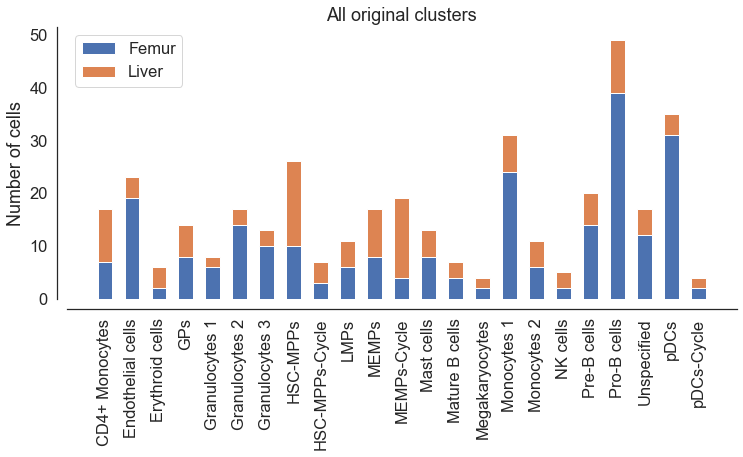

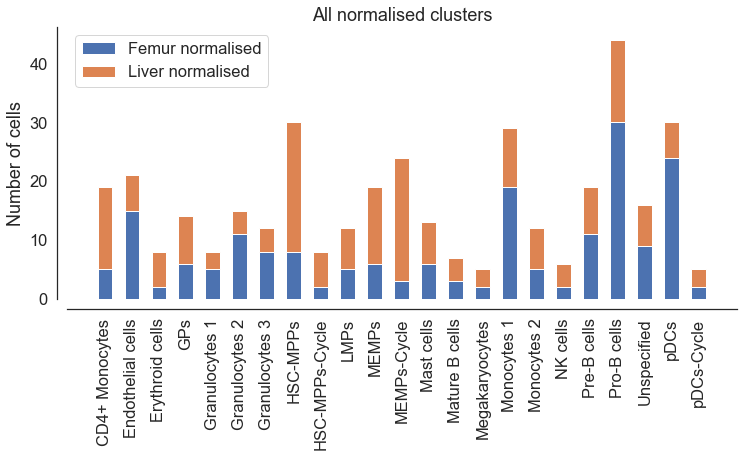

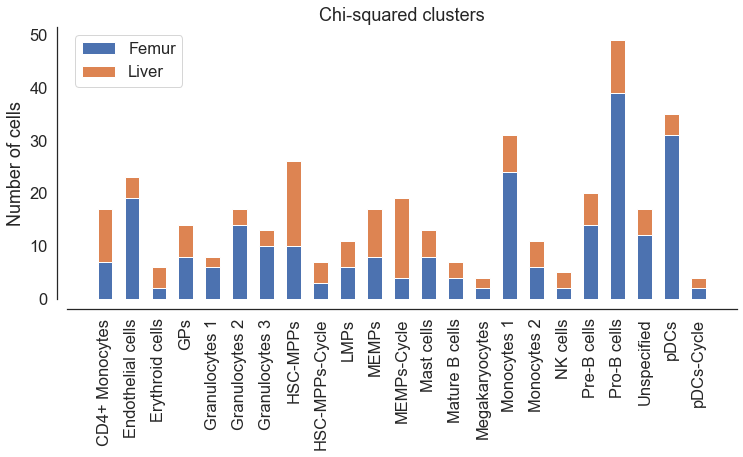

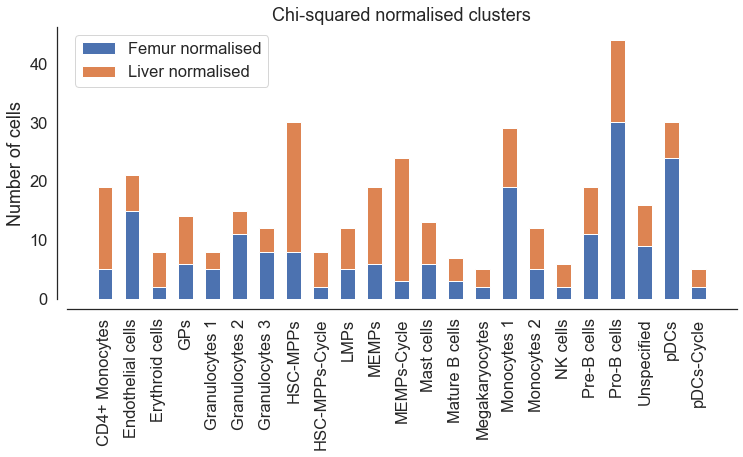

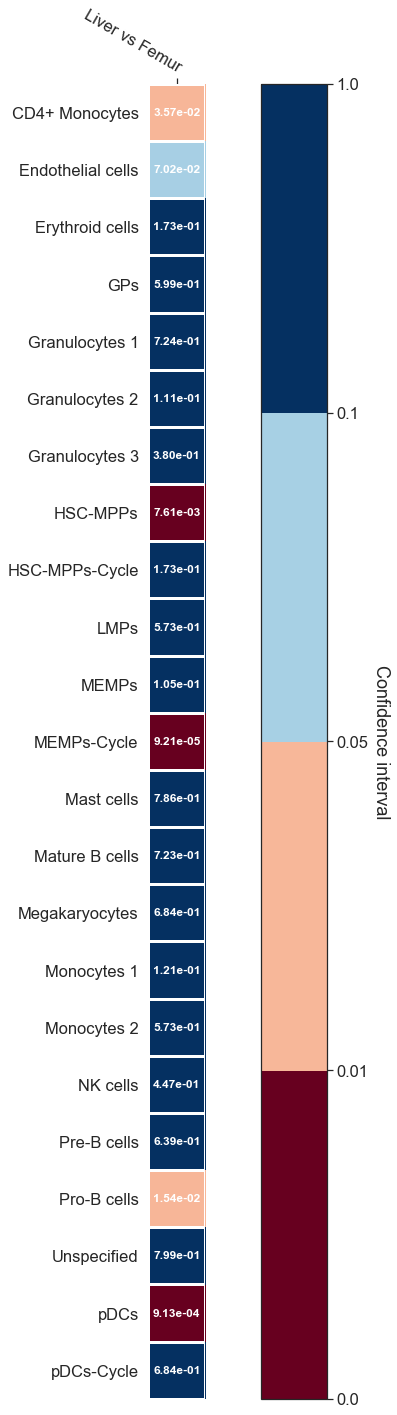

In [12]:
dataframe = pd.DataFrame(columns=["group1", "group2", "Cluster", "p-value"])
dictionaryOut = {}

p_vals    = []
group1    = []
group2    = []
variables = []
palette=sns.color_palette("deep")        
for i, col1 in enumerate(df.columns):
    for j, col2 in enumerate(df.columns):
        if i<j:        
            pal = [palette[i],palette[j]]
            dd_fisher = __chi_test(df[[col1, col2]], 0.1, pal)

            if dd_fisher is not None:
                display(dd_fisher)

                num_clusters = len(dd_fisher.index.tolist())


                group1    += ([col1] * num_clusters)
                group2    += ([col2] * num_clusters)
                variables += dd_fisher.index.tolist()
                p_vals    += dd_fisher["p-value"].tolist()
                
            print()
            print()
dataframe["group1"]  = group1
dataframe["group2"]  = group2
dataframe["Cluster"] = variables
dataframe["p-value"] = p_vals

if dataframe.shape[0] > 0:
    dictionaryOut["Median"] = dataframe
    plotHeatmaps(dictionaryOut)